---

# Spatio-Temporal Data Science Demo-Project
Hello & welcome! 🌍🕰️  

## Objective 🎯
The primary goal of this project is to **predict which plots of land in the canton of Lucerne will be built upon in the future**.

## Dataset 📊
The predictions are based on a dataset titled:
> **Arealstatistik der Schweiz: Vergleich 1979/85, 1992/97, 2004/09, 2013/18**

This dataset categorizes the land of the canton of Lucerne into **4 main categories** and **17 sub-categories**. Each plot of land (totaling 149,293 objects) has four observations, each taken in one of the following time-frames: 
1. 1979/85
2. 1992/97
3. 2004/09
4. 2013/18

### Main Categories:
1. **Siedlungsflächen** (Settlement areas)
2. **Landwirtschaftsflächen** (Agricultural areas)
3. **Bestockte Flächen** (Stocked areas)
4. **Unproduktive Flächen** (Unproductive areas)

### Sub-Categories:
1. **Industrie- und Gewerbeareal** (Industrial and commercial area)
2. **Gebäudeareal** (Building area)
3. **Verkehrsflächen** (Transportation areas)
4. **Besondere Siedlungsflächen** (Special settlement areas)
5. **Erholungs- und Grünanlagen** (Recreation and green areas)
6. **Obst-, Reb- und Gartenbauflächen** (Fruit, vineyard, and horticultural areas)
7. **Ackerland** (Agricultural land)
8. **Naturwiesen, Heimweiden** (Natural meadows, home pastures)
9. **Alpwirtschaftsflächen** (Alpine farming areas)
10. **Wald (ohne Gebüschwald)** (Forest excluding shrub forest)
11. **Gebüschwald** (Shrub forest)
12. **Gehölze** (Shrubs and bushes)
13. **Stehende Gewässer** (Standing waters)
14. **Fliessgewässer** (Flowing waters)
15. **Unproduktive Vegetation** (Unproductive vegetation)
16. **Vegetationslose Flächen** (Areas without vegetation)
17. **Gletscher, Firn** (Glaciers, firn)

### More Information:
For additional details on the dataset, visit the [official page](https://www.geo.lu.ch/meta/?metauid=ASTATVGL_DS&version=2).

---


# Imports

In [1]:
import geopandas as gpd
from folium.plugins import MarkerCluster
import folium
import numpy as np
import pandas as pd
import libpysal
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


## Data

In [2]:
# Path to data
file_path = 'data/arealstatistik/data_gpkg/daten/ASTATVGL_DS_V2_20201231.gpkg'


In [3]:
# Read the GeoPackage file
raw_data = gpd.read_file(file_path)


# Exploration

## Transform Coordinates to lat, lon

In [4]:
# Create a GeoDataFrame from DataFrame, assuming 'geometry' already contains geometry objects
gdf = gpd.GeoDataFrame(raw_data, geometry='geometry')

# Set the original coordinate reference system to CH1903+/LV95 (EPSG:2056) for GeoDataFrame
gdf.set_crs("EPSG:2056", inplace=True)

# Reproject the geometries to the new coordinate reference system WGS 84 (EPSG:4326)
gdf = gdf.to_crs("EPSG:4326")

# Transform to lat, lon coordinates:
gdf['longitude'] = gdf.geometry.x
gdf['latitude'] = gdf.geometry.y

# Drop unnecessary columns
gdf.drop(columns=['BFS_NR', 'FJ09', 'FJ18', 'FJ85', 'FJ97', 'RELI'], inplace=True)


## Find land that has been built upon since last observation

In [5]:
gdf['neubau_97-85'] = np.where((gdf['AS85R_4'] != 1) & (gdf['AS97R_4'] == 1), 1, 0)
gdf['neubau_09-97'] = np.where((gdf['AS97R_4'] != 1) & (gdf['AS09R_4'] == 1), 1, 0)
gdf['neubau_18-09'] = np.where((gdf['AS09R_4'] != 1) & (gdf['AS18_4'] == 1), 1, 0)


## Get Spatial Weights

In [7]:
# Calculate spatial weights. Here, `k=1` specifies that for each point,
# the closest point is considered as its neighbor.
weights = libpysal.weights.KNN.from_dataframe(gdf, k=25)

# For each observation, find its neighbors
neighbors = weights.neighbors


## Count neighbouring Plots that have been built upon

In [8]:
def count_neighbors_with_condition(row, neighbors_dict, column_name, condition_value):
    # Get the neighbors for the current row index
    current_neighbors = neighbors_dict.get(row.name, [])

    # Count the neighbors that meet the condition
    count = sum(gdf.loc[neighbor, column_name] == condition_value for neighbor in current_neighbors)

    return count

# Apply the function to each row and assign the result to a new column
gdf['neighboring_1_count_AS85'] = gdf.apply(count_neighbors_with_condition,
                                       axis=1,
                                       neighbors_dict=neighbors,
                                       column_name='AS85R_4',
                                       condition_value=1)

gdf['neighboring_1_count_AS97'] = gdf.apply(count_neighbors_with_condition,
                                       axis=1,
                                       neighbors_dict=neighbors,
                                       column_name='AS97R_4',
                                       condition_value=1)

gdf['neighboring_1_count_AS09'] = gdf.apply(count_neighbors_with_condition,
                                       axis=1,
                                       neighbors_dict=neighbors,
                                       column_name='AS09R_4',
                                       condition_value=1)

gdf['neighboring_1_count_AS18'] = gdf.apply(count_neighbors_with_condition,
                                       axis=1,
                                       neighbors_dict=neighbors,
                                       column_name='AS18_4',
                                       condition_value=1)


In [ ]:
# Safe gdf
gdf.to_file("data/preprocessed_gdf.gpkg", driver="GPKG")


# Modelling

## Prepare Data for Model Training

In [10]:
gdf_85 = gdf[['AS85R_17', 'neighboring_1_count_AS85', 'neubau_97-85']]
gdf_97 = gdf[['AS97R_17', 'neighboring_1_count_AS97', 'neubau_09-97']]
gdf_09 = gdf[['AS09R_17', 'neighboring_1_count_AS09', 'neubau_18-09']]
gdf_18 = gdf[['AS18_17', 'neighboring_1_count_AS18', 'latitude', 'longitude']]

gdf_85.rename(columns = {'AS85R_17': 'category_17', 'neighboring_1_count_AS85': 'neighboring_1_count', 'neubau_97-85': 'neubau'}, inplace = True)
gdf_97.rename(columns = {'AS97R_17': 'category_17', 'neighboring_1_count_AS97': 'neighboring_1_count', 'neubau_09-97': 'neubau'}, inplace = True)
gdf_09.rename(columns = {'AS09R_17': 'category_17', 'neighboring_1_count_AS09': 'neighboring_1_count', 'neubau_18-09': 'neubau'}, inplace = True)
gdf_18.rename(columns = {'AS18_17': 'category_17', 'neighboring_1_count_AS18': 'neighboring_1_count'}, inplace = True)


data = pd.concat([gdf_85, gdf_97, gdf_09], axis=0)


/tmp/ipykernel_26516/2575329987.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_85.rename(columns = {'AS85R_17': 'category_17', 'neighboring_1_count_AS85': 'neighboring_1_count', 'neubau_97-85': 'neubau'}, inplace = True)
/tmp/ipykernel_26516/2575329987.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_97.rename(columns = {'AS97R_17': 'category_17', 'neighboring_1_count_AS97': 'neighboring_1_count', 'neubau_09-97': 'neubau'}, inplace = True)
/tmp/ipykernel_26516/2575329987.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation

## First Model Training (Bagging)

In [11]:
# Extracting the features and target variable
X = data[['category_17', 'neighboring_1_count']]
y = data['neubau']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a logistic regression model
base_estimator = LogisticRegression()

# Create a bagging classifier with logistic regression as the base estimator
bagging_model = BaggingClassifier(base_estimator=base_estimator, n_estimators=10, random_state=42)

# Fit the model
bagging_model.fit(X_train, y_train)

# Make predictions
y_pred = bagging_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


/home/mo/code/mooorice/spatial_analysis_ch/spatial_env/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.9882408978595457


/home/mo/code/mooorice/spatial_analysis_ch/spatial_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    132784
           1       0.00      0.00      0.00      1580

    accuracy                           0.99    134364
   macro avg       0.49      0.50      0.50    134364
weighted avg       0.98      0.99      0.98    134364



/home/mo/code/mooorice/spatial_analysis_ch/spatial_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mo/code/mooorice/spatial_analysis_ch/spatial_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model Evaluation 🧪

**Observation**: This model (Bagging Classifier with Logistic Regression estimator) does not perform well.  
While the accuracy seems suspiciously high for a first attempt, a closer look at the 'macro avg' reveals a more concerning picture. The values here are comparable to random assignment, or even worse.

**Root Cause**: The primary issue appears to be the **imbalanced nature of the dataset**.

### Next Steps 🛠️
To address this, we will consider some techniques to enhance our predictions and achieve better results. We will compare a RandomForest Classifier with up- or downsampled data against a Logistic Regression with balanced weights.

---

Classification Report for RandomForest Classifier:

              precision    recall  f1-score   support

           0       0.75      0.85      0.80    132755
           1       0.83      0.72      0.77    132819

    accuracy                           0.79    265574
   macro avg       0.79      0.79      0.79    265574
weighted avg       0.79      0.79      0.79    265574



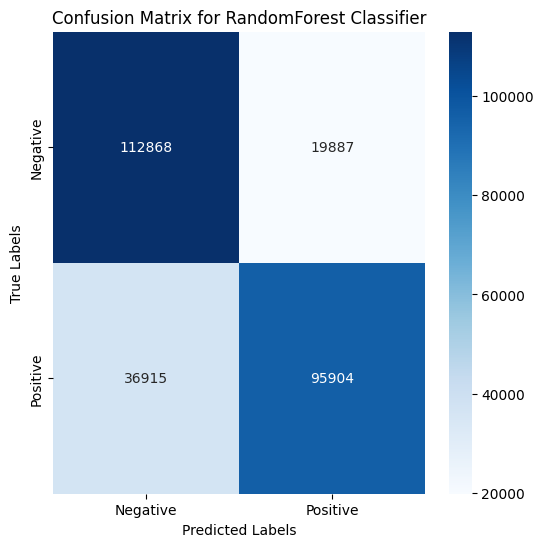

Classification Report for RandomForest Classifier:

              precision    recall  f1-score   support

           0       0.76      0.85      0.80      1617
           1       0.82      0.72      0.77      1537

    accuracy                           0.79      3154
   macro avg       0.79      0.78      0.78      3154
weighted avg       0.79      0.79      0.78      3154



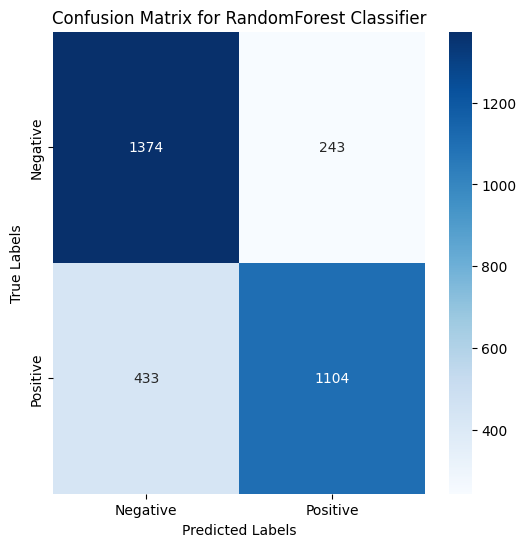

Classification Report for Logistic Regression with Balanced Weights:

              precision    recall  f1-score   support

           0       1.00      0.84      0.91    132784
           1       0.05      0.65      0.09      1580

    accuracy                           0.84    134364
   macro avg       0.52      0.75      0.50    134364
weighted avg       0.98      0.84      0.90    134364



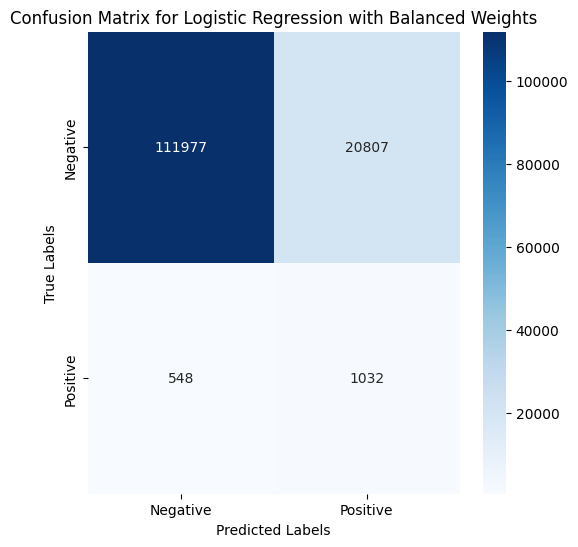

In [13]:
# Function to evaluate and visualize model performance
def evaluate_model(model, X_test, y_test, model_name):
    # Predictions
    y_pred = model.predict(X_test)

    # Classification Report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Evaluate RandomForest Classifier on upsampled data
evaluate_model(model_rf_upsampled, X_test_upsampled, y_test_upsampled, "RandomForest Classifier")

# Evaluate RandomForest Classifier on downsampled data
evaluate_model(model_rf_downsampled, X_test_downsampled, y_test_downsampled, "RandomForest Classifier")

# Evaluate Logistic Regression with balanced class weights
evaluate_model(model_lr_balanced, X_test, y_test, "Logistic Regression with Balanced Weights")


---

## Model Comparison 📊

**Observation**: Upon reviewing the findings, it's evident that the Random Forest (RF) method with both up- and downsampled data yield fairly similar scores. However, the upsampled RF method does appear to have a slight edge in terms of precision.

**Comparison**: When juxtaposed with the Logistic Regression model that uses balanced weights, both RF models (especially the upsampled one) show superior precision for the class `1`.

### Final Decision 🏆
Based on the above insights, I've chosen the **upsampled RF method** for my predictions.

---


## Prediction

In [22]:
gdf_18_pred = gdf_18[['category_17', 'neighboring_1_count']]
prediction = model_rf_upsampled.predict(gdf_18_pred)
gdf_18['neubau'] = prediction


In [30]:
print(sum(gdf_18['neubau'] == 0))
print(sum(gdf_18['neubau'] == 1))


124604

---

## Analysis Insights 🧐

**Observation**: Given the high number of positives, we might anticipate a significant surge in construction in the upcoming years. 

**Caution**: However, due to the limited dataset at our disposal, it's prudent to interpret our results as a general identification of potential building plots, rather than a concrete prediction of future construction.

## Recommendations for Further Improvements 🚀

1. **Aggregating Neighbouring Categories**: By collating the sub-categories of neighboring plots of land, we could provide the model with a richer context, potentially enhancing prediction accuracy.
2. **Incorporate Additional Datasets**: Exploring and integrating supplementary datasets might uncover previously unseen patterns or relationships, further aiding our predictive capabilities.
3. **Time Series Forecasting**: Adapting the model to utilize time series forecasting for the different observations could offer a more granular insight into potential developmental trajectories.

---


## Visualization 🌍

**Note**: Below, you'll find the code for a map visualization of all potential building plots within the canton of Lucerne. 

🔍 **Explore**: Dive in and take a look around the map!

---


In [28]:
# Create a map centered around Switzerland
switzerland_map = folium.Map(location=[47.0502, 8.3093], zoom_start=10)  # coordinates for Lucerne

# Define a color mapping based on category values
def get_color(category):
    if category == 0:
        return 'red'
    else:
        return 'blue'

# Create a marker cluster
marker_cluster = MarkerCluster().add_to(switzerland_map)

for idx, row in gdf_18.iterrows():
    if row['neubau'] == 1:
        # Create a marker with the appropriate coordinates and color, and add it directly to the marker cluster
        folium.Marker(
            [row['latitude'], row['longitude']],
            icon=folium.Icon(color=get_color(row['neubau']))
        ).add_to(marker_cluster)

# Save the map to an HTML file
switzerland_map.save('maps/lucerne_map_predicted.html')
